In [62]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [63]:
df = pd.read_csv('course final project.csv')

In [64]:
df.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,LOG,Arena,Notes
0,"Tue, Oct 24, 2023",7:30p,Los Angeles Lakers,107,Denver Nuggets,119,Box Score,NaN,19842,2:17,Ball Arena,NaN
1,"Tue, Oct 24, 2023",10:00p,Phoenix Suns,108,Golden State Warriors,104,Box Score,NaN,18064,2:33,Chase Center,NaN
2,"Wed, Oct 25, 2023",7:00p,Houston Rockets,86,Orlando Magic,116,Box Score,NaN,18846,2:14,Kia Center,NaN
3,"Wed, Oct 25, 2023",7:00p,Boston Celtics,108,New York Knicks,104,Box Score,NaN,19812,2:39,Madison Square Garden (IV),NaN
4,"Wed, Oct 25, 2023",7:00p,Washington Wizards,120,Indiana Pacers,143,Box Score,NaN,16004,2:07,Gainbridge Fieldhouse,NaN


In [65]:
df.dtypes

Date               object
Start (ET)         object
Visitor/Neutral    object
PTS                 int64
Home/Neutral       object
PTS.1               int64
Unnamed: 6         object
Unnamed: 7         object
Attend.             int64
LOG                object
Arena              object
Notes              object
dtype: object

In [66]:
# Garder les colonnes Date, Visitor, Home, Attend et Arena
df = df[['Date', 'Visitor/Neutral', 'Home/Neutral', 'Attend.', 'Arena']]

In [67]:
# Renommer les colonnes
df.rename(columns={'Visitor/Neutral': 'Away', 'Home/Neutral': 'Home', 'Attend.': 'Attendance'}, inplace=True)

In [68]:
# Suppression du play-in et des playoffs après le 14 avril
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] <= '2024-04-14']
df = df.sort_values(by="Date")

In [69]:
df.shape

(1231, 5)

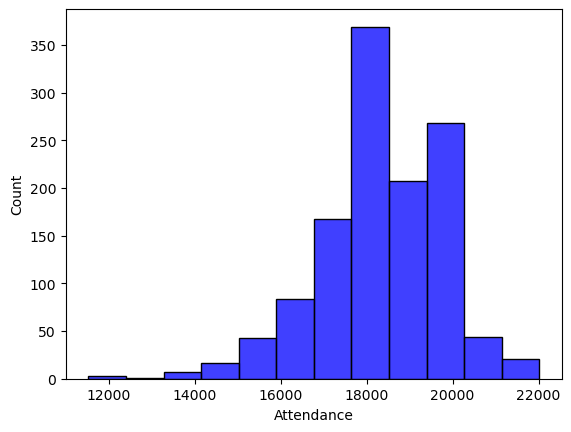

In [70]:
# Visulation de la distribution de la colonne Attendance
sns.histplot(df["Attendance"], bins=12, color="blue")
plt.show()

In [71]:
# Encodage des colonnes Away, Home et Arena
le = LabelEncoder()
for col in ['Away', 'Home', 'Arena']:
    df[col] = le.fit_transform(df[col])

df.head()

,Date,Away,Home,Attendance,Arena
0,2023-10-24,13,7,19842,2
1,2023-10-24,23,9,18064,5
13,2023-10-25,24,12,19370,6
12,2023-10-25,6,26,18947,11
11,2023-10-25,25,28,18206,7


In [72]:
# Split les données selon times series
X = df.drop(columns=['Attendance', 'Date'])  # Features
y = df['Attendance']  # Target

tscv = TimeSeriesSplit(n_splits=5)

In [49]:
# Création de l'arbre de décision
param_grid = {
    'max_depth': [3, 5, 10, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(tree, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)

grid_search.fit(X, y)

print("Best hyperparameters :", grid_search.best_params_)
print("Best MAE :", -grid_search.best_score_)

Bests hyperparameters : {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best MAE : 585.5663890824623


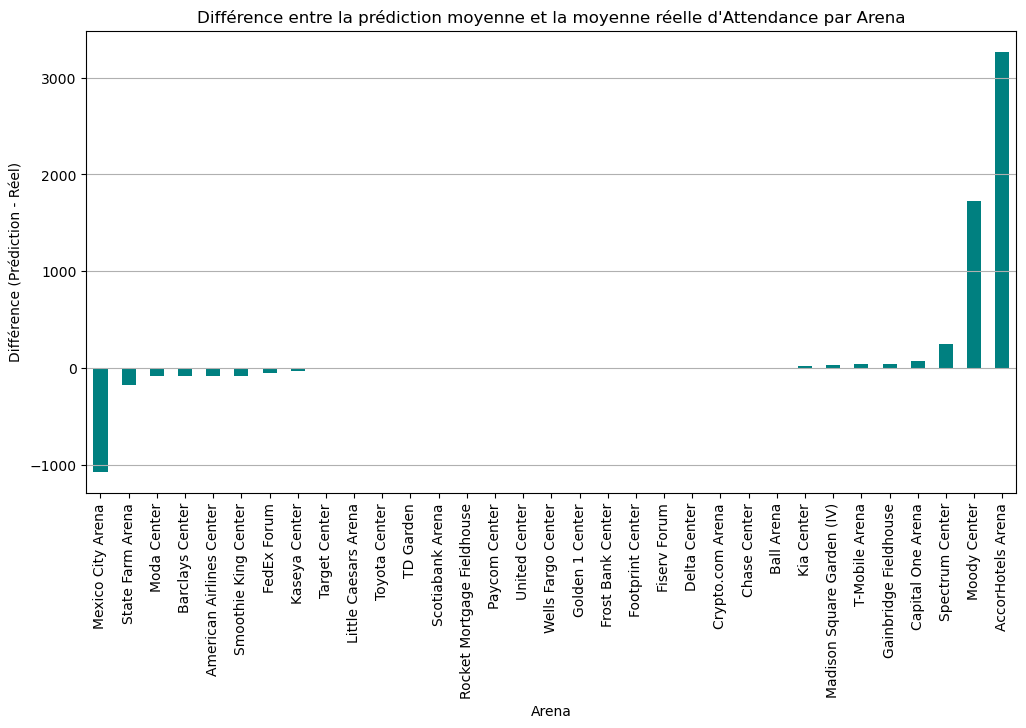

In [58]:
# Ajouter les prédictions à DataFrame

df['Predictions'] = best_tree.predict(X)

# Calculer la moyenne réelle et prédite par Arena
arena_avg_real = df.groupby('Arena')['Attendance'].mean()
arena_avg_pred = df.groupby('Arena')['Predictions'].mean()

# Calculer la différence entre la moyenne réelle et la moyenne prédite
arena_diff = arena_avg_pred - arena_avg_real

# Trier par la différence pour mieux visualiser
arena_diff_sorted = arena_diff.sort_values()

# Inverser le LabelEncoding pour récupérer les noms d'arènes
arena_diff_sorted.index = le.inverse_transform(arena_diff_sorted.index)

# 📊 Afficher la différence sous forme de graphique à barres
plt.figure(figsize=(12, 6))
arena_diff_sorted.plot(kind='bar', color='teal')

# Ajouter des titres et labels
plt.title("Différence entre la prédiction moyenne et la moyenne réelle d'Attendance par Arena")
plt.xlabel("Arena")
plt.ylabel("Différence (Prédiction - Réel)")
plt.xticks(rotation=90)
plt.grid(axis='y')

# Afficher le graphique
plt.show()